# Import Libs

In [586]:
import math
import re
import os
import networkx as nx
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import pandas as pd
import nxviz as nv
from networkx.algorithms.community import girvan_newman, louvain_communities, louvain_partitions

# Extraindo Personagens

## Descobrindo nomes arquivos de entrada

In [587]:
def list_path_temporadas() -> list:
    dir_dados = 'data'
    diretorios = os.listdir(dir_dados)
    diretorios_temporadas = [f'{dir_dados}/{f}' for f in diretorios if os.path.isdir(f'{dir_dados}/{f}')]
    return diretorios_temporadas

In [588]:
def list_path_epi(path_temporada) -> list:
    diretorios = os.listdir(path_temporada)
    path_episodios = [f'{path_temporada}/{f}' for f in diretorios if os.path.isfile(f'{path_temporada}/{f}')]
    return path_episodios

# Extrair Personagens

In [589]:
def regex_nome_personagem(string):
    string_upper = string.upper()
    regex_result = re.search('^[^"\[]*?:', string_upper)
    if regex_result:
        string_personagem = regex_result.group(0)
        if re.search('((^EXT)|(^INT))', string_upper):
            return None
        return regex_result

In [590]:
def nome_personagem(personagem_str):
    if 'ARYA' in personagem_str or 'ARAY' in personagem_str:
        return 'ARYA'
    elif 'BAELISH' in personagem_str:
        return 'LITTLEFINGER'
    elif 'DAENERYS' in personagem_str or 'DAENERYS' in personagem_str or 'DENERYS' in personagem_str or 'DANY' in personagem_str:
        return 'DAENERYS'
    elif 'TYRION' in personagem_str:
        return 'TYRION'
    elif 'CATELYN' in personagem_str:
        return 'CATELYN'
    elif 'DOLOROUS EDD' == personagem_str:
        return 'EDD'
    elif 'JON SNOW' == personagem_str:
        return 'JON'
    elif 'ROOSE' == personagem_str:
        return 'ROOSE'
    elif 'RAMSAY' in personagem_str:
        return 'RAMSAY'
    elif 'CERSEI' in personagem_str:
        return 'CERSEI'
    elif 'JAIME' in personagem_str:
        return 'JAIME'
    return personagem_str

In [591]:
def tratamento_nome_personagem(personagem_str):
    p = re.compile('((\(.*\))*)(\s?):')
    personagem_str = p.sub('', personagem_str) 
    p = re.compile('\s$')
    personagem_str = p.sub('', personagem_str)
    
    if 'YOUNG ' in personagem_str:
        return personagem_str.replace('YOUNG ', '')
    elif ' VOICE' in personagem_str:
        return personagem_str.replace('\'S VOICE', '')    
 
    return nome_personagem(personagem_str)    

In [592]:
def contem_digito(personagem_str):
    return any(char.isdigit() for char in personagem_str)

In [593]:
def extrair_personagens_episodio(path_arquivo, personagens, personagens_figurantes):
    with open(path_arquivo, 'r') as file:
        for line in file:
            personagem = regex_nome_personagem(line)

            if personagem:
                personagem_str = tratamento_nome_personagem(personagem.group(0))
                                
                contains_digit = any(char.isdigit() for char in personagem_str)
                
                if contains_digit:
                    p = re.compile('(\s?).(\d)')
                    personagem_figurante = p.sub('', personagem_str)
                    personagens_figurantes.add(personagem_figurante)
                else:
                    x = re.search('((^ALL\s)|(^ALL$)|(^AN?\s))', personagem_str)
                    if not x:
                        personagens.add(personagem_str)

In [594]:
def personagem_invalido(personagem_str):
    contains_voice_str = 'VOICE ' in personagem_str
    contains_comma_str = ',' in personagem_str
    contains_dot_str = '.' in personagem_str
    contains_cut_to_str = 'CUT TO' in personagem_str
    contains_men_woman_crowd_str = 'MEN' in personagem_str or 'MAN' in personagem_str or 'CROWD' in personagem_str
    return contains_comma_str or contains_voice_str or contains_dot_str or contains_cut_to_str or contains_men_woman_crowd_str

In [595]:
def extrair_personagens():
    personagens = set()
    
    personagens_figurantes = set()
    
    for path_temporada in list_path_temporadas():
        for path_episodio in list_path_epi(path_temporada):
            extrair_personagens_episodio(path_episodio, personagens, personagens_figurantes)
            
    personagens_principais = set()
    for personagem in personagens:
        if personagem_invalido(personagem):
            continue
             
        if personagem not in personagens_figurantes:
            personagens_principais.add(personagem)    
             
    return personagens_principais

In [596]:
personagens = extrair_personagens()

# Divisão Cenas

In [597]:
def linha_atual_dialogo(personagem_regex):
    return False if not personagem_regex else True
    

In [598]:
def personagens_na_mesma_cena(dialogos, personagens):
    personagens_cena = set()
    
    for dialogo in dialogos:
        nome_personagem = regex_nome_personagem(dialogo).group(0)
        nome_personagem = tratamento_nome_personagem(nome_personagem)
        
        if personagem_invalido(nome_personagem):
            continue
        
        if nome_personagem in personagens:    
            personagens_cena.add(nome_personagem)
        
    return personagens_cena

In [599]:
def nova_cena(ultima_linha_dialogo, linha_atual_contem_dialogo, dialogo_iniciado_capitulo, line):
    if 'scene' in line:
        return True
    if '- - -' in line:
        return True
    if re.search('((^EXT)|(^INT))', line):
        return True
    if re.search('^CUT TO', line):
        return True
    if not ultima_linha_dialogo and dialogo_iniciado_capitulo:
        if linha_atual_contem_dialogo:
            return True
    return False
            

In [600]:
def identificacao_cenas(personagens):
    personagens_cenas_serie = []
    for path_temporada in list_path_temporadas():
        for path_episodio in list_path_epi(path_temporada):
            
            with open(path_episodio, 'r') as file:
                dialogos = []
                ultima_linha_dialogo = False
                gerar_quebra_cenario = False
                dialogo_iniciado_capitulo = False
                for line in file:
                    
                    if line == '\n':
                        continue
                    
                    personagem_regex = regex_nome_personagem(line)

                    linha_atual_contem_dialogo = linha_atual_dialogo(personagem_regex)                   

                    if personagem_regex:
                        dialogo_iniciado_capitulo = True
                        dialogos.append(line)
                    elif nova_cena(ultima_linha_dialogo, linha_atual_contem_dialogo, dialogo_iniciado_capitulo, line):
                        personagens_cena = personagens_na_mesma_cena(dialogos, personagens)
                        if len(personagens_cena) > 1:
                            personagens_cenas_serie.append(personagens_cena)
                        dialogos = []
                    
                    ultima_linha_dialogo = linha_atual_contem_dialogo         
                        
    return personagens_cenas_serie                    

In [601]:
personagens_cenas = identificacao_cenas(personagens)

# Gerar Conexões dos Personagens

In [602]:
def extrair_personagens_recorrentes(personagens_cenas, frequencia_minima):
    frequencia_personagem = {}
    for cena in personagens_cenas:
        for personagem in cena:
            if personagem not in frequencia_personagem.keys():
                frequencia_personagem[personagem] = 0
            frequencia_personagem[personagem] += 1
            
    for key in frequencia_personagem.keys():
        frequencia_personagem[key] /= len(personagens_cenas)
            
    personagens_recorrentes = set()
    for personagem, frequencia in frequencia_personagem.items():
        if frequencia >= frequencia_minima:
            personagens_recorrentes.add(personagem)
            
    return personagens_recorrentes

In [603]:
def extrair_dados_grafo_personagens(persoangens, personagens_cenas):    
    personagens_recorrentes = extrair_personagens_recorrentes(personagens_cenas, 0.01)
    
    indice_personagem = 0
    map_personagem = {}
    for personagem in personagens:
        if personagem in personagens_recorrentes:
            map_personagem[personagem] = indice_personagem
            indice_personagem += 1
            
    conexoes_personagens = {}
    
    for personagens_cena in personagens_cenas:
        personagens_cena_list = list(personagens_cena)
        for i in range(0, len(personagens_cena)):
            if personagens_cena_list[i] not in personagens_recorrentes:
                continue
            for j in range(i+1, len(personagens_cena)):
                if personagens_cena_list[j] not in personagens_recorrentes:
                    continue

                personagem_1 = min(personagens_cena_list[i], personagens_cena_list[j])
                personagem_2 = max(personagens_cena_list[i], personagens_cena_list[j])
                
                if personagem_1 not in conexoes_personagens.keys():
                    conexoes_personagens[personagem_1] = {}
                    
                if personagem_2 not in conexoes_personagens[personagem_1].keys():
                    conexoes_personagens[personagem_1][personagem_2] = 0
                    
                conexoes_personagens[personagem_1][personagem_2] += 1

    conexoes = []
    
    for p1 in conexoes_personagens.keys():
        if p1 == 'NAN': 
            continue
        for p2 in conexoes_personagens[p1].keys():
            if p2 == 'NAN': 
                continue
            peso = conexoes_personagens[p1][p2]/len(personagens_cenas)
            cenas = conexoes_personagens[p1][p2]
            
            conexoes.append({'p1': p1, 'p2': p2, 'peso': peso, 'cenas': cenas})

    return pd.DataFrame.from_dict(conexoes)


## Criação do grafo

In [604]:
df = extrair_dados_grafo_personagens(personagens, personagens_cenas)

In [605]:
G = nx.from_pandas_edgelist(
    df, source='p1', target='p2',
    edge_attr=['peso', 'cenas']
)

## Medidas de Centralidade

### Centralidade

In [606]:
centralidade = nx.degree_centrality(G)

In [607]:
centralidade = sorted(centralidade.items(), key=lambda x:x[1], reverse=True)

In [608]:
centralidade[0:10]

[('JON', 0.7571428571428571),
 ('ARYA STARK', 0.7571428571428571),
 ('SANSA', 0.6714285714285714),
 ('TYRION', 0.6714285714285714),
 ('JAIME', 0.6571428571428571),
 ('DAENERYS', 0.6428571428571428),
 ('BRAN', 0.6),
 ('CERSEI', 0.6),
 ('JORAH', 0.5857142857142857),
 ('THEON', 0.5428571428571428)]

### Centralidade Autovetor

In [609]:
centralidade_autovetor = nx.eigenvector_centrality(G)


In [610]:
centralidade_autovetor = sorted(centralidade_autovetor.items(), key=lambda x:x[1], reverse=True)
centralidade_autovetor[0:10]

[('JON', 0.20904923160936162),
 ('ARYA STARK', 0.206967704177172),
 ('SANSA', 0.19931286416022212),
 ('TYRION', 0.19412211318530376),
 ('DAENERYS', 0.191296570148564),
 ('JAIME', 0.19007588964270225),
 ('JORAH', 0.1828049268690812),
 ('BRAN', 0.17912386219492776),
 ('THEON', 0.17412526526308206),
 ('GREY WORM', 0.17296600691910433)]

### Centralidade Pagerank

In [611]:
pagerank = nx.pagerank(G)


In [612]:
pagerank = sorted(pagerank.items(), key=lambda x:x[1], reverse=True)
pagerank[0:10]

[('ARYA STARK', 0.029564197365686964),
 ('JON', 0.02869380010316428),
 ('TYRION', 0.025090056861504353),
 ('JAIME', 0.02499515862591267),
 ('SANSA', 0.024873679418513404),
 ('DAENERYS', 0.024481569606649604),
 ('CERSEI', 0.022994293908584807),
 ('BRAN', 0.022616499936006746),
 ('JORAH', 0.022105744516642427),
 ('SAM', 0.020560034078750105)]

### Centralidade Proximidade

In [613]:
centralidade_proximidade = nx.closeness_centrality(G)


In [614]:
centralidade_proximidade = sorted(centralidade_proximidade.items(), key=lambda x:x[1], reverse=True)
centralidade_proximidade[0:10]

[('JON', 0.8045977011494253),
 ('ARYA STARK', 0.8045977011494253),
 ('SANSA', 0.7526881720430108),
 ('TYRION', 0.7526881720430108),
 ('JAIME', 0.7446808510638298),
 ('DAENERYS', 0.7368421052631579),
 ('BRAN', 0.7142857142857143),
 ('CERSEI', 0.7142857142857143),
 ('JORAH', 0.7070707070707071),
 ('THEON', 0.6862745098039216)]

## Detecção de Comunidades

In [615]:
comunidades = louvain_communities(G, weight='peso')
partition = louvain_partitions(G, weight='peso')

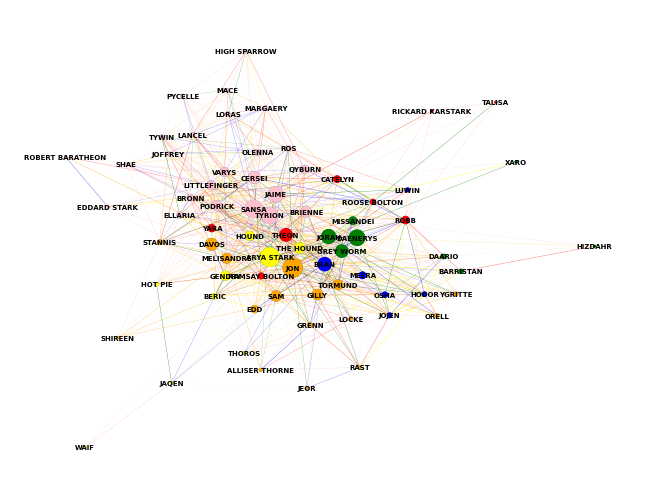

In [616]:
pos = nx.spring_layout(G, k=1, iterations=200)

d = nx.degree(G)

node_key = [item[0] for item in centralidade_autovetor]
node_values = [math.exp(item[1] * 25) for item in centralidade_autovetor]

edge_values = [item[1] for item in centralidade_autovetor]


peso_personagens = {}
for item in centralidade_autovetor:
    peso_personagens[item[0]] = item[1]

colors_list = ['pink', 'green', 'blue', 'red', 'orange', 'yellow', 'brown']

color_edges = []

for personagem in node_key:
    for i in range(0, len(comunidades)):
        if personagem in comunidades[i]:
            color_edges.append(colors_list[i])
            break

nx.draw(G, pos=pos, nodelist=node_key, node_size=node_values, edge_color=color_edges, font_weight='black', font_size=5, width=edge_values, with_labels=True)

for i in range(0, len(comunidades)):
    node_values = [math.exp(peso_personagens[personagem] * 25) for personagem in comunidades[i]]
    nx.draw_networkx_nodes(G, pos, nodelist=comunidades[i], node_color=colors_list[i], edgecolors=colors_list[i], node_size=node_values)
